# Yelp Photo Classifier

This project focuses on developing a sophisticated computer vision system to classify business photos from Yelp into four distinct categories: Food, Drink, Interior, and Exterior. Leveraging deep learning techniques, the project explores various approaches to build and optimize a high-performance image classification model.

If you have trouble in installing tensorflow in your computer, you may consider using Google Colab for this project.

## Part 1 How Yelp Uses Deep Learning to Classify Business Photos?

Yelp hosts tens of millions of photos uploaded by Yelpers from all around the world. The wide variety of these photos provides a rich window into local businesses, a window we’re only just peeking through today.

One way we’re trying to open that window is by developing a photo understanding system which allows us to create semantic data about individual photographs. The data generated by the system has been powering our recent launch of tabbed photo browsing as well as our first attempts at content-based photo diversification.

You can check more details about Yelp's practices at [here](https://engineeringblog.yelp.com/2015/10/how-we-use-deep-learning-to-classify-business-photos-at-yelp.html)


![food](https://engineeringblog.yelp.com/images/posts/2015-10-14-photo-classification/image02.png)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from PIL import Image
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inlinec

Let's first upload the file images.npy and labels.npy and load the images dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
images = np.load('/content/drive/My Drive/Colab Notebooks/Assignment3_DL_2324/images.npy') # SHAPE: (1024, 256, 256, 3) -> (N_SAMPLES, HEIGHT, WIDTH, CHANNELS)
labels = np.load('/content/drive/My Drive/Colab Notebooks/Assignment3_DL_2324/labels.npy') # SHAPE: (1024,) -> (N_SAMPLES,). Label encoded: 0, 1, 2, 3

print('Images shape:', images.shape)
print('Labels shape:', labels.shape)
print('Labels match the image at the respective 0 to 1024 position.')

Images shape: (1024, 256, 256, 3)
Labels shape: (1024,)
Labels match the image at the respective 0 to 1024 position.


There are four types of the images on Yelp: Food, Drink, Interior and Exterior

In [ ]:
np.unique(labels)

array([0, 1, 2, 3])

We visualize some random images from the dataset below:

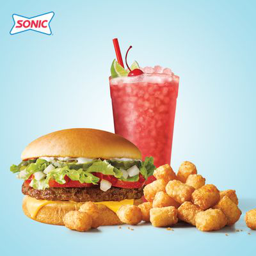

In [ ]:
# food: class 0

Image.fromarray(images[5])

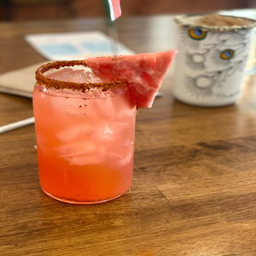

In [ ]:
# drink: class 1

Image.fromarray(images[3])

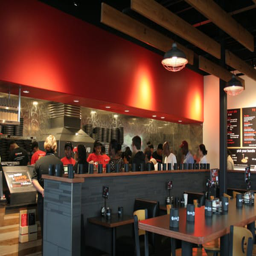

In [ ]:
# interior: class 2

Image.fromarray(images[7])

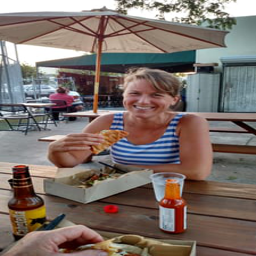

In [ ]:
# exterior: class 3

Image.fromarray(images[8])

### Part 1.1 Training a deep neural network

Practice training a deep neural network on the Yelp image dataset


Build a Deep Neural Network (DNN) with 20 hidden layers of 100 neurons each (that’s too many, but it’s the point of this question), using the RELU activation function.

Using Adam optimization, train the network on the dataset. Donot forget define your input and output layers.

Train the model for 100 epochs and use test set as the validation data during the training, explain how many parameters does the model have and whether the model will experience overfitting. You may consider plotting the losses and accuracy over epochs.

In [ ]:
# Convert the datasets to a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((images, labels))

# Shuffle the dataset and split into training and validation sets
dataset = dataset.shuffle(buffer_size=len(images), seed=123, reshuffle_each_iteration=False)
train_size = int(0.8 * len(images))  # 80% for training
test_size = len(images) - train_size # 20% for tasting that we will use as validation set

train_d = dataset.take(train_size)
test_d = dataset.skip(train_size)

# Batch and prefetch for performance
batch_size = 32
img_height = 256
img_width = 256

# Batch and prefetch
train_ds = train_d.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_d.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Check one batch of the dataset
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 256, 256, 3)
(32,)


In [ ]:
#Tailoring the learning rate
# Constants
TOTAL_IMAGES = 1024
NUM_EPOCHS = 100
STEPS_PER_EPOCH = TOTAL_IMAGES // batch_size

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate=0.0005,
  decay_steps=STEPS_PER_EPOCH * NUM_EPOCHS,
  decay_rate=0.5,
  staircase=False
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

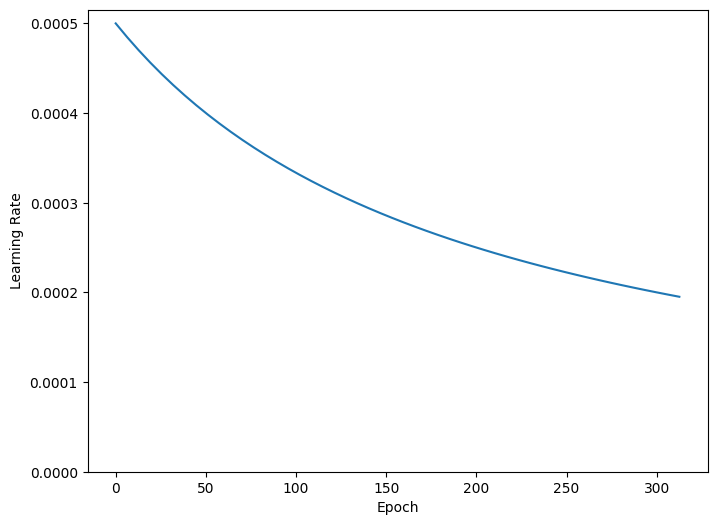

In [ ]:
step = np.linspace(0,10000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [ ]:
#Creation of the model
num_classes = len(np.unique(labels))

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Flatten(),
])

model.add(layers.Dense(100, activation='relu'))

for _ in range(19):
    model.add(layers.Dense(100, activation='relu'))

# Output layer for multi-class classification, using softmax
model.add(layers.Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 100)               19660900  
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 100)               1

In [ ]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/100
26/26 [==============================] - 6s 114ms/step - loss: 1.3840 - accuracy: 0.2625 - val_loss: 1.3685 - val_accuracy: 0.2927
Epoch 2/100
26/26 [==============================] - 2s 94ms/step - loss: 1.3534 - accuracy: 0.3199 - val_loss: 1.3437 - val_accuracy: 0.3707
Epoch 3/100
26/26 [==============================] - 2s 95ms/step - loss: 1.3253 - accuracy: 0.3480 - val_loss: 1.3127 - val_accuracy: 0.3659
Epoch 4/100
26/26 [==============================] - 2s 95ms/step - loss: 1.2426 - accuracy: 0.3810 - val_loss: 1.1887 - val_accuracy: 0.4683
Epoch 5/100
26/26 [==============================] - 2s 95ms/step - loss: 1.1745 - accuracy: 0.4225 - val_loss: 1.2017 - val_accuracy: 0.4439
Epoch 6/100
26/26 [==============================] - 2s 95ms/step - loss: 1.1520 - accuracy: 0.4518 - val_loss: 1.1533 - val_accuracy: 0.4683
Epoch 7/100
26/26 [==============================] - 2s 95ms/step - loss: 1.1104 - accuracy: 0.4933 - val_loss: 1.1481 - val_accuracy: 0.4732
Epoch

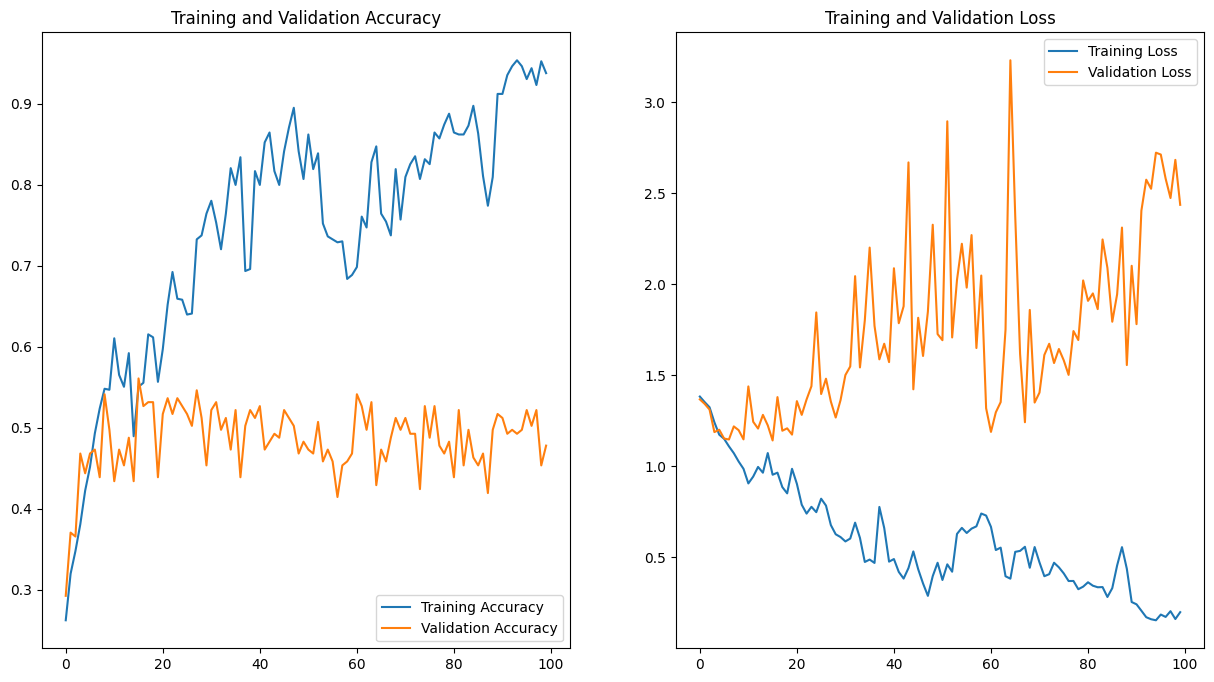

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#Basiline Model
test_loss, test_accuracy = model.evaluate(test_ds)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)
print('Number of parameters:',  model.count_params())

7/7 [==============================] - 0s 9ms/step - loss: 2.4376 - accuracy: 0.4780
Test loss: 2.4375603199005127
Test accuracy: 0.47804877161979675
Number of parameters: 19853204


#Observations:
The model has 19853204 parameters.

The training and validation plots for the deep neural network, constructed with an excessively deep architecture of 20 hidden layers, manifest clear indications of overfitting. As the training progresses through 100 epochs, we observe that the training accuracy improves steadily, which typically would suggest a model is learning effectively. However, the validation accuracy does not mirror this improvement beyond a certain point, leveling off significantly, a classic hallmark of overfitting. Furthermore, the validation loss exhibits erratic behavior, with marked spikes and an overall lack of a declining trend, underscoring the model's challenges in generalizing to unseen data. The early epochs show promise with both accuracies rising in tandem, but this trend falters as training extends, revealing that while the model is becoming proficient in memorizing the training data, as evidenced by the descending training loss, it fails to sustain this performance on the validation set.